# 50.039 Theory and Practice of Deep Learning | Coding Homework 1 - SVM Pipeline Exercise
### Joel Huang, 1002530
Purpose of this exercise is to recap the general ML workflow.

## Task 0: Examining and Splitting dataset
The description of the dataset is taken from www.robots.ox.ac.uk/~vgg/data/flowers/17/README.txt

```
This set contains images of flowers belonging to 17 different categories.
The images were acquired by searching the web and taking pictures. There are 80 images for each category. 
```

The task is to split the data into the following sets:
* Training: 40 per class
* Validation: 20 per class
* Test: 20 per class

### Q: What is the difference between this (stratified sampling) and a random 50-25-25 split of the entire dataset?
Since the number of samples from each class is fairly small and equal, a random 50-25-25 split will not ensure exact class representation in the training, validation and test sets. An extreme example which can illustrate the perils of this: we might have one entire class present in the test set but not in the training set. The model will not have trained on this class data at all. When it is time to test the model, it will likely fail at classifying the test cases from this particular unseen class. If the number of samples from each class is large, then random sampling has less of an effect on the distributions of the training, validation and test sets.

## Task I: Split data



Use `train_test_split` twice as per this method: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

(680, 512) (340, 512) (340, 512)
(680,) (340,) (340,)


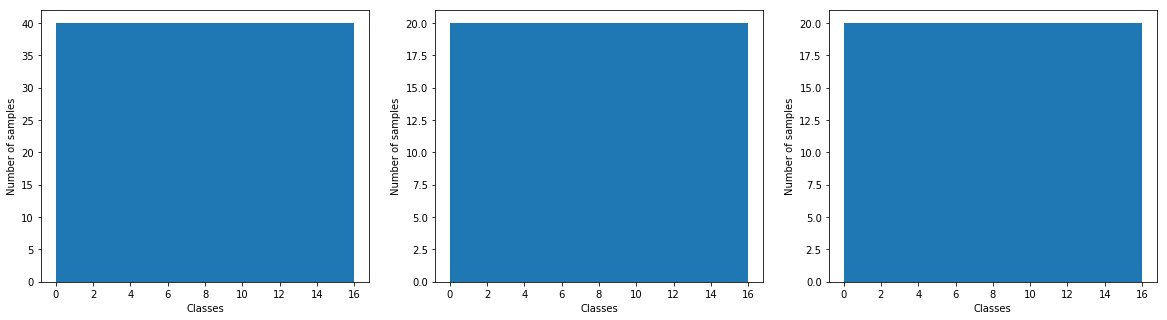

In [1]:
import numpy as np

# get data paths sorted by category
paths = np.array([l.strip('\n') for l in open('data/files.txt')])

# shuffle into training 40, validation 20, and test 20
x = np.array([np.load('feats/' + prefix + '_ft.npy') for prefix in paths])
y = np.repeat(np.arange(17), 80)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, paths_holding, paths_test = train_test_split(x, y, paths, test_size=20*17, stratify=y)
x_train, x_val, y_train, y_val, paths_train, paths_val = train_test_split(x_train, y_train, paths_holding, test_size=20*17, stratify=y_train)

# verify shapes
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

# verify stratified
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,5))
fig.add_subplot(131)
plt.ylabel("Number of samples")
plt.xlabel("Classes")
plt.hist(y_train, bins=17)
fig.add_subplot(132)
plt.ylabel("Number of samples")
plt.xlabel("Classes")
plt.hist(y_val, bins=17)
fig.add_subplot(133)
plt.ylabel("Number of samples")
plt.xlabel("Classes")
plt.hist(y_test, bins=17)
plt.show()

### Saving splits as `.npy` files

In [2]:
import os
if not os.path.exists('splits'):
    os.mkdir('splits')

np.save('splits/x_train.npy', x_train)
np.save('splits/x_val.npy', x_val)
np.save('splits/x_test.npy', x_test)
np.save('splits/y_train.npy', y_train)
np.save('splits/y_val.npy', y_val)
np.save('splits/y_test.npy', y_test)

## Task II: Optimizing Hyperparameters

### Using `sklearn.multiclass.OneVsRestClassifier`
Also known as one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only `n_classes` classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.

This strategy can also be used for multilabel learning, where a classifier is used to predict multiple labels for instance, by fitting on a 2-d matrix in which cell `[i, j]` is 1 if sample i has label j and 0 otherwise.

### Finding the best regularization constant
The regularization constant is scored using the mean accuracy on the given test data and labels. In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.

In [3]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

regularization_constants = [0.01, 0.1, 0.1**0.5, 1, 10**0.5, 10, 100**0.5]
scores = []

for c in regularization_constants:
    svm = OneVsRestClassifier(estimator=SVC(C=c, kernel="linear"))
    svm.fit(x_train, y_train)
    scores.append(svm.score(x_val, y_val))
    
best_c = regularization_constants[np.argmax(scores)]
best_score = np.max(scores)
print("Best pair | c={}, score={}".format(best_c, best_score))

Best pair | c=0.01, score=0.9058823529411765


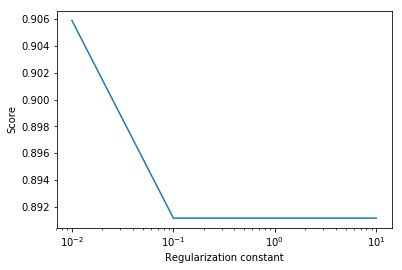

In [4]:
plt.plot(regularization_constants, scores)
plt.xlabel("Regularization constant")
plt.ylabel("Score")
plt.xscale("log")
plt.show()

## Task III: Training on train+val

In [5]:
x_train_val = np.concatenate((x_train, x_val))
y_train_val = np.concatenate((y_train, y_val))

### Performance on test set

The mean accuracy over all 17 classes can be seen below, along with other metrics like precision, recall and f1.

In [6]:
optimal_svm = OneVsRestClassifier(estimator=SVC(C=best_c, kernel="linear"))
optimal_svm.fit(x_train_val, y_train_val)
y_pred = optimal_svm.predict(x_test)

from sklearn.metrics import classification_report, accuracy_score
print("Mean accuracy: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Mean accuracy: 0.9294117647058824
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        20
           1       0.79      0.95      0.86        20
           2       0.90      0.90      0.90        20
           3       1.00      0.90      0.95        20
           4       1.00      1.00      1.00        20
           5       0.95      0.95      0.95        20
           6       1.00      0.95      0.97        20
           7       0.77      0.85      0.81        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       0.95      0.95      0.95        20
          11       0.95      0.90      0.92        20
          12       0.95      0.95      0.95        20
          13       0.73      0.80      0.76        20
          14       0.91      1.00      0.95        20
          15       1.00      0.95      0.97        20
          16       1.00      1.00      1.00    

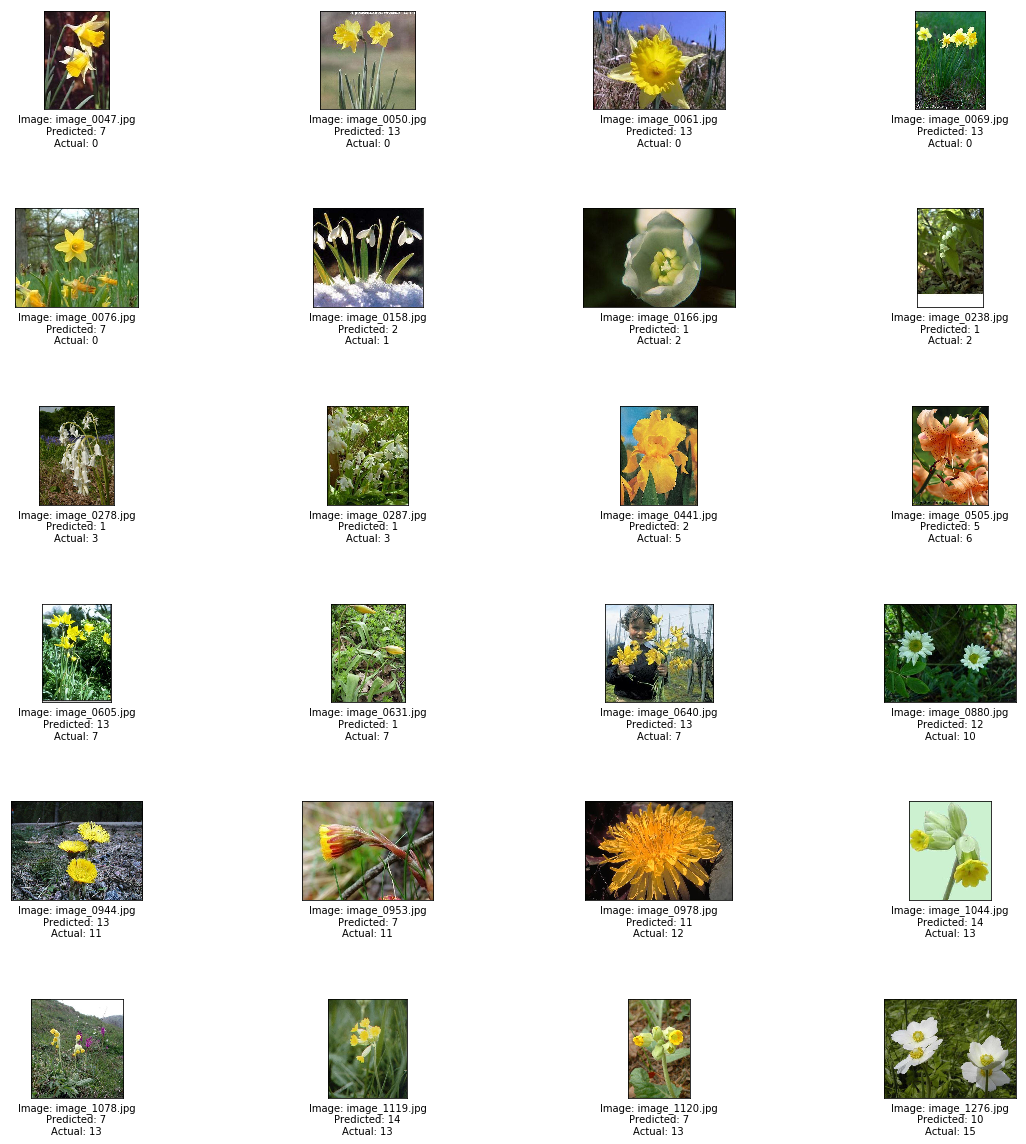

In [7]:
failed_indices = np.where(y_test!=y_pred)[0]

fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=1)

import math
num_rows = math.ceil(len(failed_indices)/4)

results = []
for i in range(len(failed_indices)):
    img = paths_test[failed_indices[i]]
    pred = y_pred[failed_indices[i]]
    actual = y_test[failed_indices[i]]
    results.append({'image':  img,
                    'pred':   pred,
                    'actual': actual})

results = sorted(results, key=lambda k: k['image'])

for i in range(len(results)):
    fig.add_subplot(num_rows, 4, i+1)
    plt.xticks([]), plt.yticks([])
    image =  'Image: {}'.format(results[i]['image'])
    pred =   'Predicted: {}'.format(results[i]['pred'])
    actual = 'Actual: {}'.format(results[i]['actual'])
    plt.xlabel(image + '\n' + pred + '\n' + actual)
    plt.imshow(plt.imread('data/' + results[i]['image']))
plt.show()

### Final comments on results / Attempting to explain the SVM's confusion
After running the entire pipeline a few times, it seems that there are mainly confusions between class 0 and class 7, and especially class 11 and 12. It might be useful to run the pipeline over multiple times and look at the most confused classes, rather than to take one result as the final one.

### Comparison with results from RBF kernel
The RBF kernel was also tried multiple times, with only a marginally higher accuracy improvement over the linear kernel.